In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

import bt_mle_utils as mle
from simulation_utils import *

## Barbell

In [39]:
n1 = 4
n2 = 4
n_bridge = 1

index = np.random.choice(n1 * n2, n_bridge, replace = False)
i1 = np.repeat(np.arange(n1), n2)[index]
i2 = np.tile(np.arange(n1), n2)[index] + n1

print(i1)
print(i2)

[3]
[4]


In [52]:
def get_game_matrix_barbell_design(n1, n2, n_bridge, L, bridge_L, beta):
    N = len(beta)
    game_matrix = np.zeros((N,N))
    A = get_barbell_adj_no_bridge(n1 = n1, n2 = n2,)
    
    index = np.random.choice(n1 * n2, n_bridge, replace = False)
    i1 = np.repeat(np.arange(n1), n2)[index]
    i2 = np.tile(np.arange(n1), n2)[index] + n1
    bridges = [(x,y) for x, y in zip(i1,i2)]
#     print(i1)
#     print(i2)
    A[i1, i2] = 1
    A[n1:,:n1] = A[:n1,n1:].copy().T
#     print(bridges)
    
    edge_list = get_edge(A)
#     print(A)
    
    for edge in edge_list:
        i, j = edge
        if (i, j) in bridges:
            total = bridge_L
        else:
            total = L
        pij = np.exp(beta[i] - beta[j]) / (1 + np.exp(beta[i] - beta[j]))
        nij = np.random.binomial(n = total, p = pij, size = 1)
        game_matrix[i,j], game_matrix[j,i] = nij, total - nij
    return game_matrix

def get_barbell_adj_no_bridge(n1 = 50, n2 = 50):
    n = n1 + n2
    A = np.zeros((n,n))
    A[:n1,:n1] = get_complete_adj(n = n1)
    A[n1:,n1:] = get_complete_adj(n = n2)
    return A

def get_edge(A, list = True):
    '''
    edge indices in the upper-triangle
    '''
    edge = np.where(np.triu(A))
    if list:
        return [(x,y) for x, y in zip(edge[0],edge[1])]
    else:
        return zip(edge[0], edge[1])

In [53]:
n1, n2 = 3, 5
n = n1 + n2
n_bridge = 1

t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta = get_beta_with_gap(n, delta)
beta *= kappa / (np.max(beta) - np.min(beta))

g = get_game_matrix_barbell_design(n1 = n1, n2 = n2, n_bridge = n_bridge, L = 1, bridge_L = 10, beta = beta)
g

array([[0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 4., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 6., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 0.]])

In [ ]:
factor = 2
n1, n2 = 50 * factor, 50 * factor
# bridge_list = np.arange(m) * 50
n_bridge = 1

B = 2

n = n1 + n2
k = 10
t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta = get_beta_with_gap(n, delta)
beta *= kappa / (np.max(beta) - np.min(beta))

In [ ]:
factor = 2
n1, n2 = 50 * factor, 50 * factor
# bridge_list = np.arange(m) * 50
bridge = 1

B = 2

n = n1 + n2
k = 10
t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta = get_beta_with_gap(n, delta)
beta *= kappa / (np.max(beta) - np.min(beta))

L = 1
bridge_L_list = np.array([1, 5, 10, 20, 40, 60, 80, 100, 200])
m = len(bridge_L_list)

l_infty_beta_list = np.zeros(m)
std_l_infty_beta_list = np.zeros(m)
bar_l_infty_beta_list = np.zeros((m,2))
rank_beta_list = np.zeros(m)
topk_beta_list = np.zeros(m)

np.random.seed(0)

for ix, bridge_L in enumerate(bridge_L_list):

    l_infty_beta_, rank_beta_, topk_beta_ = np.zeros(B), np.zeros(B), np.zeros(B)
    
    for b in range(B):
        game_matrix = get_game_matrix_barbell_design(n1 = n1, n2 = n2, n_bridge, L = L, bridge_L = bridge_L, beta = beta)
        
        beta_hat = get_mle_reg(game_matrix)
        l_infty_beta_[b], rank_beta_[b], topk_beta_[b] = get_error(beta, beta_hat, k = k)
        
        
    l_infty_beta_list[ix] = np.mean(l_infty_beta_)
    std_l_infty_beta_list[ix] = np.std(l_infty_beta_)
    bar_l_infty_beta_list[ix, :] = np.quantile(l_infty_beta_, 0.05), np.quantile(l_infty_beta_, 0.95)
    
    rank_beta_list = np.mean(rank_beta_)
    topk_beta_list = np.mean(topk_beta_)  
    
    print(bridge_L)

In [ ]:
# plt.fill_between(bridge_list / (n1 * n2), l_infty_beta_list - 2*std_l_infty_beta_list, l_infty_beta_list + 2*std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(bridge_L_list, bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], alpha = 0.2)
plt.plot(bridge_L_list, l_infty_beta_list)

plt.xlabel('bridge L')
plt.ylabel('l-infinity error')
# plt.savefig('barbell-1.pdf')

In [4]:
def beta_hat_bridge_L(bridge_L, L = 1, n = 50, n_bridge = 1):
    n1, n2 = n, n
    B = 2

    n = n1 + n2
    k = 10
    t = 0.9
    kappa = np.log(t / (1 - t))
    delta = 1
    beta = get_beta_with_gap(n, delta)
    beta *= kappa / (np.max(beta) - np.min(beta))
    
    np.random.seed(0)

    game_matrix = get_game_matrix_barbell_design(n1 = n1, n2 = n2, n_bridge = n_bridge, L = L, bridge_L = bridge_L, beta = beta)

    beta_hat = get_mle_reg(game_matrix) 
    
    return beta, beta_hat

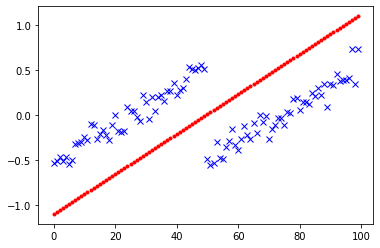

In [7]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 10, L = 10, n = 50, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

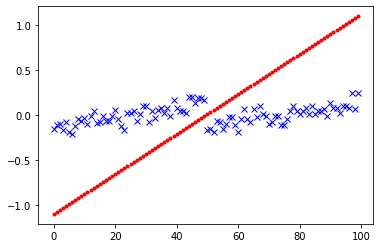

In [6]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 1, L = 1, n = 50, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

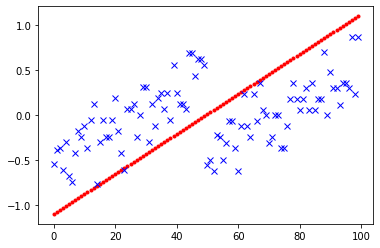

In [8]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 100, L = 1, n = 50, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

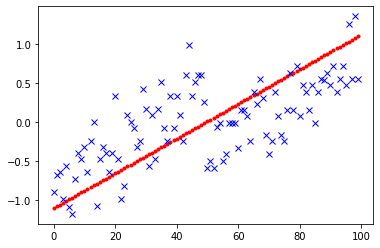

In [9]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 5000, L = 1, n = 50, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

In [ ]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 5000, n = 100)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

In [ ]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 5, n = 200)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

In [ ]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 5000, n = 200)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

In [ ]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 500000, n = 200)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

In [ ]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 500000, n = 50)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

## Use additivity

In [272]:
def get_beta_2(n1, n2):
    n = n1 + n2
    t = 0.9
    kappa = np.log(t / (1 - t))
    delta = 1
    beta = get_beta_with_gap(n, delta)
    beta *= kappa / (np.max(beta) - np.min(beta))
    return beta

def get_mle_barbell_additivity(game_matrix, n1, n2):
    g1 = game_matrix[:n1, :n1]
    beta_hat1 = get_mle_reg(g1)
    
    g2 = game_matrix[n1:, n1:]
    beta_hat2 = get_mle_reg(g2)
    
    bridges = game_matrix[:n1, n1:] + game_matrix[n1:, :n1].T
    bridges = np.where(bridges)
    bridges = [(x, y + n1) for x, y in zip(bridges[0],bridges[1])]
#     print(bridges)
    
    beta_diff = np.infty
    ix = (-1, -1)
    for e in bridges:
        i, j = e
        win, loss = game_matrix[i, j], game_matrix[j, i]
        p_hat = np.clip(win / (win + loss), 0.1, 0.9)
        
        diff_hat = np.log(p_hat/(1 - p_hat))
        if abs(diff_hat) < abs(beta_diff):
            beta_diff = diff_hat
            ix = (i, j)
#     print(beta_diff)
    beta_hat2 += -beta_diff - beta_hat2[ix[1] - n1] + beta_hat1[ix[0]]
    
    beta = np.zeros(game_matrix.shape[0])
    beta[:n1] = beta_hat1.copy()
    beta[n1:] = beta_hat2.copy()
    beta = beta - np.mean(beta)
    
    return beta


def beta_hat_bridge_L(bridge_L, L = 1, n = 50, n_bridge = 1):
    n1, n2 = n, n
    beta = get_beta_2(n1, n2)

    game_matrix = get_game_matrix_barbell_design(n1 = n1, n2 = n2, n_bridge = n_bridge, L = L, bridge_L = bridge_L, beta = beta)
    beta_hat = get_mle_reg(game_matrix) 
    return beta, beta_hat

def beta_hat_bridge_L_additivity(bridge_L, L = 1, n = 50, n_bridge = 1):
    n1, n2 = n, n
    beta = get_beta_2(n1, n2)

    game_matrix = get_game_matrix_barbell_design(n1 = n1, n2 = n2, n_bridge = n_bridge, L = L, bridge_L = bridge_L, beta = beta)
    beta_hat = get_mle_barbell_additivity(game_matrix, n1, n2)
    return beta, beta_hat

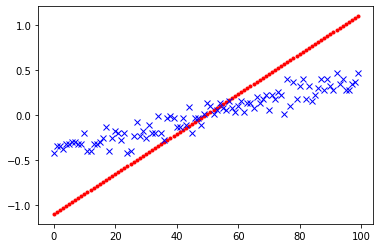

In [136]:
np.random.seed(0)
beta, beta_hat = beta_hat_bridge_L_additivity(bridge_L = 10, L = 1, n = 50, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

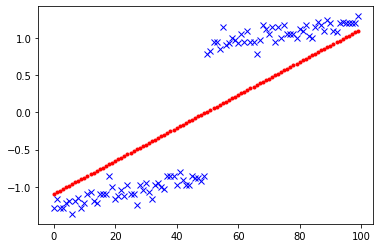

In [137]:
beta, beta_hat = beta_hat_bridge_L_additivity(bridge_L = 10, L = 1, n = 50, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

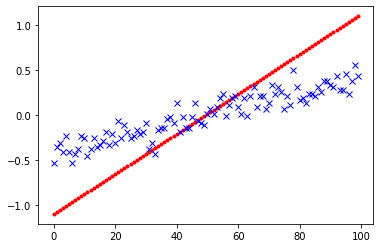

In [138]:
beta, beta_hat = beta_hat_bridge_L_additivity(bridge_L = 100, L = 1, n = 50, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

(0.6491617215459449, 253802, 0.7)

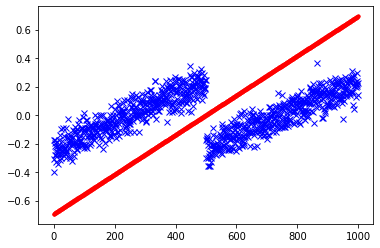

In [139]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 10, L = 1, n = 500, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

(0.5736703194207429, 31442, 0.6)

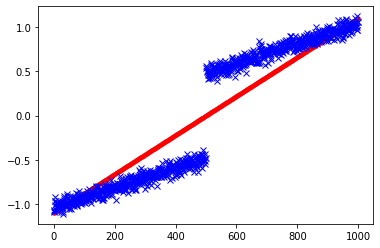

In [140]:
beta, beta_hat = beta_hat_bridge_L_additivity(bridge_L = 10, L = 1, n = 500, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

(0.6424806436891426, 244702, 0.8)

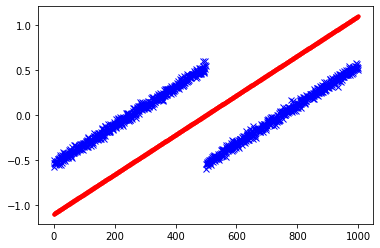

In [251]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 100, L = 10, n = 500, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

(0.18263016765331846, 10222, 0.4)

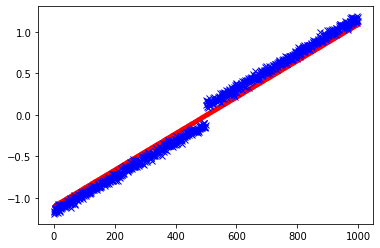

In [252]:
beta, beta_hat = beta_hat_bridge_L_additivity(bridge_L = 100, L = 10, n = 500, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

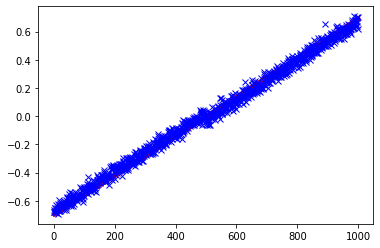

In [143]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 1000000, L = 10, n = 500, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

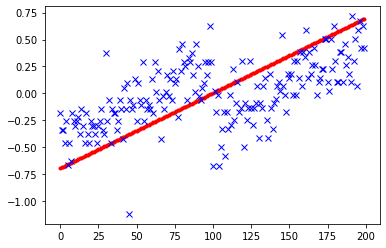

In [144]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 5000, n = 100, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

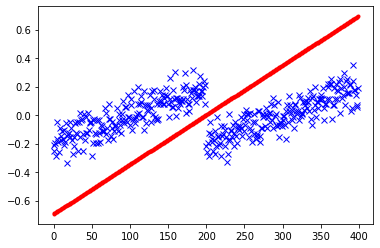

In [145]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 5, n = 200, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

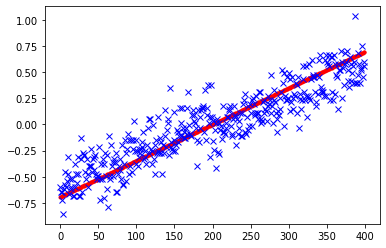

In [146]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 500000, n = 200, n_bridge = 1)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')

(0.3786562728727267, 4325, 0.3)

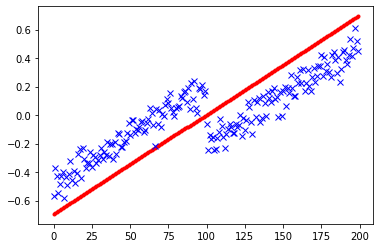

In [373]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 100, L = 10, n = 100, n_bridge = 10)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

(0.1842452322988754, 1379, 0.3)

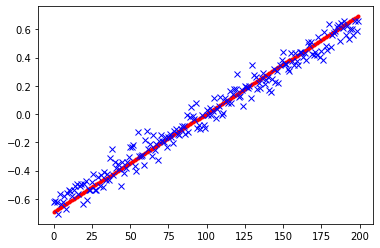

In [374]:
beta, beta_hat = beta_hat_bridge_L_additivity(bridge_L = 100, L = 10, n = 100, n_bridge = 10)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

(0.948928558427009, 253803, 0.8)

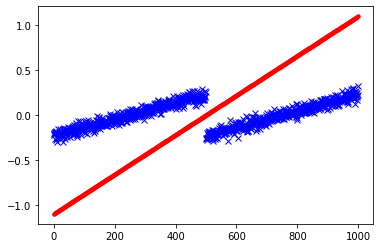

In [276]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 1, L = 1, n = 500, n_bridge = 10)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

(0.8074359415049154, 231230, 0.8)

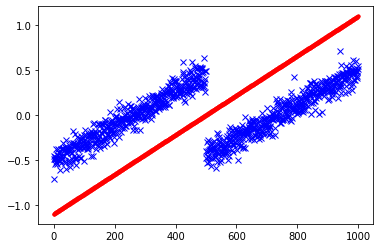

In [253]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 100, L = 1, n = 500, n_bridge = 10)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

(0.7555129560165221, 85909, 0.5)

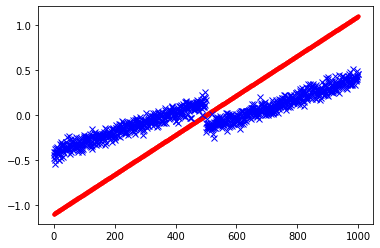

In [254]:
beta, beta_hat = beta_hat_bridge_L_additivity(bridge_L = 100, L = 1, n = 500, n_bridge = 10)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

In [268]:
def get_beta(n):
    t = 0.9
    kappa = np.log(t / (1 - t))
    delta = 1
    beta = get_beta_with_gap(n, delta)
    beta *= kappa / (np.max(beta) - np.min(beta))
    return beta

def beta_hat_complete(L = 1, n = 50):
    beta = get_beta(n)

    game_matrix = get_game_matrix_complete(n = n, L = L, beta = beta)
    beta_hat = get_mle_reg(game_matrix) 
    return beta, beta_hat

In [263]:
def get_game_matrix_complete(n, L, beta):
    game_matrix = np.zeros((n,n))
    A = get_complete_adj(n)
    edge_list = get_edge(A)
    
    for edge in edge_list:
        i, j = edge
        pij = np.exp(beta[i] - beta[j]) / (1 + np.exp(beta[i] - beta[j]))
        nij = np.random.binomial(n = L, p = pij, size = 1)
        game_matrix[i,j], game_matrix[j,i] = nij, L - nij
    return game_matrix

(0.7180453325805777, 8774, 0.7)

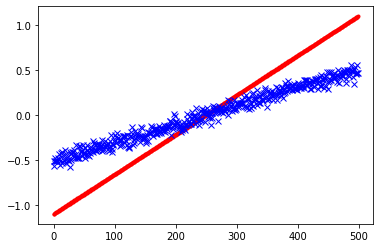

In [269]:
beta, beta_hat = beta_hat_complete(L = 1, n = 500)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

(0.5007189463272587, 70130, 0.7)

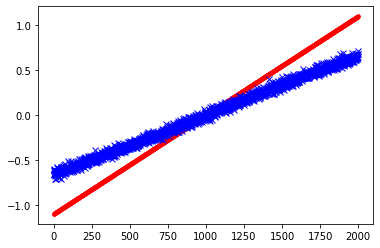

In [275]:
beta, beta_hat = beta_hat_complete(L = 1, n = 2000)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

# Different distribution of beta

In [316]:
def get_beta_overlap(n1, n2, overlap = 0):
    n = n1 + n2
    
    t = 0.8
    kappa = np.log(t / (1 - t))
    delta = 1
    beta0 = get_beta_with_gap(n, delta)
    beta0 *= kappa / (np.max(beta0) - np.min(beta0))
    beta1 = beta0[:n1].copy()
    
    beta2 = beta0[-n2:].copy()
#     overlap = min(overlap, min(n1, n2))
    shift = (beta0[1] - beta0[0]) * overlap
    beta2 -= shift
    
    beta = np.zeros(n)
    beta[:n1] = beta1
    beta[n1:] = beta2
    
    beta -= np.mean(beta)
    
    return beta

In [279]:
def beta_hat_bridge_L(bridge_L, L = 1, n = 50, n_bridge = 1, overlap = 0):
    n1, n2 = n, n
    beta = get_beta_overlap(n1, n2, overlap)

    game_matrix = get_game_matrix_barbell_design(n1 = n1, n2 = n2, n_bridge = n_bridge, L = L, bridge_L = bridge_L, beta = beta)
    beta_hat = get_mle_reg(game_matrix) 
    
    return beta, beta_hat

In [280]:
def beta_hat_bridge_L_additivity(bridge_L, L = 1, n = 50, n_bridge = 1, overlap = 0):
    n1, n2 = n, n
    beta = get_beta_overlap(n1, n2, overlap)

    game_matrix = get_game_matrix_barbell_design(n1 = n1, n2 = n2, n_bridge = n_bridge, L = L, bridge_L = bridge_L, beta = beta)
    beta_hat = get_mle_barbell_additivity(game_matrix, n1, n2)
    
    return beta, beta_hat

In [283]:
def get_mle_barbell_additivity(game_matrix, n1, n2):
    g1 = game_matrix[:n1, :n1]
    beta_hat1 = get_mle_reg(g1)
    
    g2 = game_matrix[n1:, n1:]
    beta_hat2 = get_mle_reg(g2)
    
    bridges = game_matrix[:n1, n1:] + game_matrix[n1:, :n1].T
    bridges = np.where(bridges)
    bridges = [(x, y + n1) for x, y in zip(bridges[0],bridges[1])]
#     print(bridges)
    
    beta_diff = np.zeros(len(bridges))
    for ei, e in enumerate(bridges):
        i, j = e
        win, loss = game_matrix[i, j], game_matrix[j, i]
        p_hat = np.clip(win / (win + loss), 0.1, 0.9)
        
        diff_hat = np.log(p_hat/(1 - p_hat))
        beta_diff[ei] = -diff_hat - beta_hat2[j - n1] + beta_hat1[i]
#     print(beta_diff)
    beta_hat2 += np.mean(beta_diff)
    
    beta = np.zeros(game_matrix.shape[0])
    beta[:n1] = beta_hat1.copy()
    beta[n1:] = beta_hat2.copy()
    beta = beta - np.mean(beta)
    
    return beta

(0.26690254267936925, 4018, 0.5)

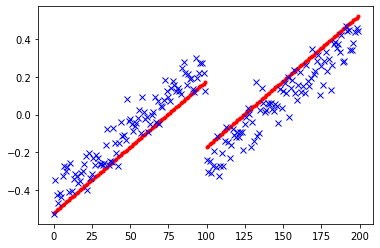

In [377]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 100, L = 10, n = 100, n_bridge = 10, overlap = 50)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

(0.17193173460208083, 1929, 0.2)

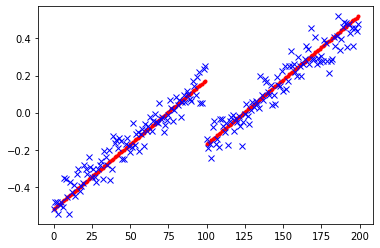

In [376]:
beta, beta_hat = beta_hat_bridge_L_additivity(bridge_L = 100, L = 10, n = 100, n_bridge = 10, overlap = 50)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

(0.19979177315014596, 2950, 0.5)

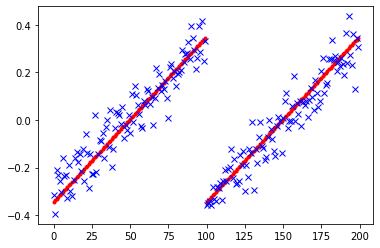

In [378]:
beta, beta_hat = beta_hat_bridge_L(bridge_L = 100, L = 10, n = 100, n_bridge = 10, overlap = 100)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

(0.18223881815719223, 2666, 0.4)

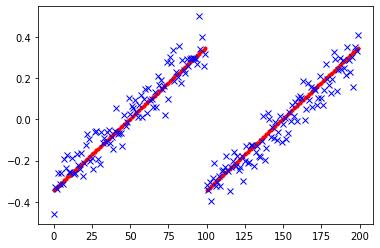

In [379]:
beta, beta_hat = beta_hat_bridge_L_additivity(bridge_L = 100, L = 10, n = 100, n_bridge = 10, overlap = 100)
plt.plot(beta, 'r.')
plt.plot(beta_hat, 'bx')
get_error(beta, beta_hat, k = 10)

In [154]:
diff = 0.8
np.exp(diff) / (1 + np.exp(diff))

0.6899744811276125

In [361]:
factor = 1
n1, n2 = 50 * factor, 50 * factor
# bridge_list = np.arange(m) * 50
n_bridge = 10

bridge_L = 10
L = 10
k = 5

B = 100

overlap_list = np.array([-20, -15, -10, -5, -1, 0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 55, 60, 65, 70, 75, 80]) * factor
m = len(overlap_list)

l_infty_beta_list = np.zeros(m)
std_l_infty_beta_list = np.zeros(m)
bar_l_infty_beta_list = np.zeros((m,2))
rank_beta_list = np.zeros(m)
topk_beta_list = np.zeros(m)

l_infty_beta_add_list = np.zeros(m)
std_l_infty_beta_add_list = np.zeros(m)
bar_l_infty_beta_add_list = np.zeros((m,2))
rank_beta_add_list = np.zeros(m)
topk_beta_add_list = np.zeros(m)

np.random.seed(0)

for ix, overlap in enumerate(overlap_list):

    l_infty_beta_, rank_beta_, topk_beta_ = np.zeros(B), np.zeros(B), np.zeros(B)
    l_infty_beta_add_, rank_beta_add_, topk_beta_add_ = np.zeros(B), np.zeros(B), np.zeros(B)
    
    for b in range(B):
        beta = get_beta_overlap(n1, n2, overlap)
        game_matrix = get_game_matrix_barbell_design(n1 = n1, n2 = n2, n_bridge = 10, L = L, bridge_L = bridge_L, beta = beta)
        
        beta_hat = get_mle_reg(game_matrix)
        l_infty_beta_[b], rank_beta_[b], topk_beta_[b] = get_error(beta, beta_hat, k = k)
        
        beta_hat = get_mle_barbell_additivity(game_matrix, n1, n2)
        l_infty_beta_add_[b], rank_beta_add_[b], topk_beta_add_[b] = get_error(beta, beta_hat, k = k)
        
        
    l_infty_beta_list[ix] = np.mean(l_infty_beta_)
    std_l_infty_beta_list[ix] = np.std(l_infty_beta_)
    bar_l_infty_beta_list[ix, :] = np.quantile(l_infty_beta_, 0.05), np.quantile(l_infty_beta_, 0.95)
    
    rank_beta_list[ix] = np.mean(rank_beta_)
    topk_beta_list[ix] = np.mean(topk_beta_)  
    
    l_infty_beta_add_list[ix] = np.mean(l_infty_beta_add_)
    std_l_infty_beta_add_list[ix] = np.std(l_infty_beta_add_)
    bar_l_infty_beta_add_list[ix, :] = np.quantile(l_infty_beta_add_, 0.05), np.quantile(l_infty_beta_add_, 0.95)
    
    rank_beta_add_list[ix] = np.mean(rank_beta_add_)
    topk_beta_add_list[ix] = np.mean(topk_beta_add_)
    
    print(overlap)

-20
-15
-10
-5
-1
0
1
5
10
15
20
25
30
35
40
50
55
60
65
70
75
80


In [362]:
n_bridge

10

Text(0, 0.5, 'l-infinity error')

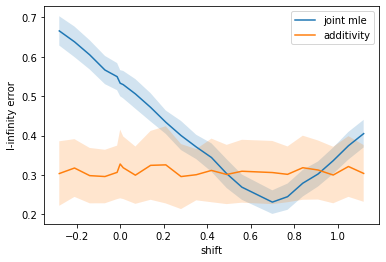

In [363]:
diff_list = (beta[1] - beta[0]) * overlap_list

# plt.figure(figsize = (9, 6))
plt.plot(diff_list, l_infty_beta_list)
plt.plot(diff_list, l_infty_beta_add_list)
plt.legend(['joint mle', 'additivity'])

# plt.fill_between(diff_list, bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], color = 'red', alpha = 0.2)
# plt.fill_between(diff_list, bar_l_infty_beta_add_list[:,0], bar_l_infty_beta_add_list[:,1], color = 'blue', alpha = 0.2)
plt.fill_between(diff_list, l_infty_beta_list - std_l_infty_beta_list, 
                 l_infty_beta_list + std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(diff_list, l_infty_beta_add_list - std_l_infty_beta_add_list, 
                 l_infty_beta_add_list + std_l_infty_beta_add_list, alpha = 0.2)
plt.xlabel('shift')
plt.ylabel('l-infinity error')

# plt.savefig('additivity_n' + str(n1) + 'n_bridge' + str(n_bridge) + '_average' + '.pdf',bbox_inches='tight')

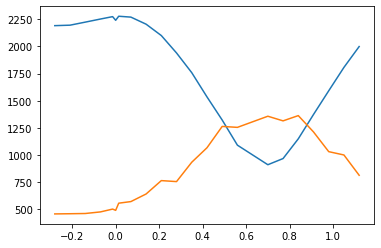

In [364]:
plt.plot(diff_list, rank_beta_list)
plt.plot(diff_list, rank_beta_add_list)

In [365]:
import pickle
with open('additivity_n' + str(n1) + '_n_bridge' + str(n_bridge) + '_bridge_L' + str(bridge_L) + '_L' + str(L) + '_average' + '.pickle', 'wb') as f:
    pickle.dump([n1, n2, n_bridge, bridge_L, L, beta, overlap_list, l_infty_beta_list,
    std_l_infty_beta_list, bar_l_infty_beta_list, rank_beta_list, topk_beta_list, l_infty_beta_add_list, 
    std_l_infty_beta_add_list, bar_l_infty_beta_add_list, rank_beta_add_list, topk_beta_add_list], f)

In [347]:
n_bridge = 10

In [349]:
L

10

In [366]:
factor = 2
n1, n2 = 50 * factor, 50 * factor
# bridge_list = np.arange(m) * 50
n_bridge = 10 * factor

bridge_L = 10
L = 10
k = 5

B = 100

overlap_list = np.array([-20, -15, -10, -5, -1, 0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 55, 60, 65, 70, 75, 80]) * factor
m = len(overlap_list)

l_infty_beta_list = np.zeros(m)
std_l_infty_beta_list = np.zeros(m)
bar_l_infty_beta_list = np.zeros((m,2))
rank_beta_list = np.zeros(m)
topk_beta_list = np.zeros(m)

l_infty_beta_add_list = np.zeros(m)
std_l_infty_beta_add_list = np.zeros(m)
bar_l_infty_beta_add_list = np.zeros((m,2))
rank_beta_add_list = np.zeros(m)
topk_beta_add_list = np.zeros(m)

np.random.seed(0)

for ix, overlap in enumerate(overlap_list):

    l_infty_beta_, rank_beta_, topk_beta_ = np.zeros(B), np.zeros(B), np.zeros(B)
    l_infty_beta_add_, rank_beta_add_, topk_beta_add_ = np.zeros(B), np.zeros(B), np.zeros(B)
    
    for b in range(B):
        beta = get_beta_overlap(n1, n2, overlap)
        game_matrix = get_game_matrix_barbell_design(n1 = n1, n2 = n2, n_bridge = 10, L = L, bridge_L = bridge_L, beta = beta)
        
        beta_hat = get_mle_reg(game_matrix)
        l_infty_beta_[b], rank_beta_[b], topk_beta_[b] = get_error(beta, beta_hat, k = k)
        
        beta_hat = get_mle_barbell_additivity(game_matrix, n1, n2)
        l_infty_beta_add_[b], rank_beta_add_[b], topk_beta_add_[b] = get_error(beta, beta_hat, k = k)
        
        
    l_infty_beta_list[ix] = np.mean(l_infty_beta_)
    std_l_infty_beta_list[ix] = np.std(l_infty_beta_)
    bar_l_infty_beta_list[ix, :] = np.quantile(l_infty_beta_, 0.05), np.quantile(l_infty_beta_, 0.95)
    
    rank_beta_list[ix] = np.mean(rank_beta_)
    topk_beta_list[ix] = np.mean(topk_beta_)  
    
    l_infty_beta_add_list[ix] = np.mean(l_infty_beta_add_)
    std_l_infty_beta_add_list[ix] = np.std(l_infty_beta_add_)
    bar_l_infty_beta_add_list[ix, :] = np.quantile(l_infty_beta_add_, 0.05), np.quantile(l_infty_beta_add_, 0.95)
    
    rank_beta_add_list[ix] = np.mean(rank_beta_add_)
    topk_beta_add_list[ix] = np.mean(topk_beta_add_)
    
    print(overlap)

-40
-30
-20
-10
-2
0
2
10
20
30
40
50
60
70
80
100
110
120
130
140
150
160


In [367]:
n_bridge

20

In [354]:
objects = []
with (open('additivity_n100_n_bridge20_bridge_L100_L10_average.pickle', "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
n1, n2, overlap_list, l_infty_beta_list, beta, std_l_infty_beta_list, \
bar_l_infty_beta_list, rank_beta_list, topk_beta_list, l_infty_beta_add_list, \
std_l_infty_beta_add_list, bar_l_infty_beta_add_list, rank_beta_add_list, topk_beta_add_list = objects[0]

Text(0, 0.5, 'l-infinity error')

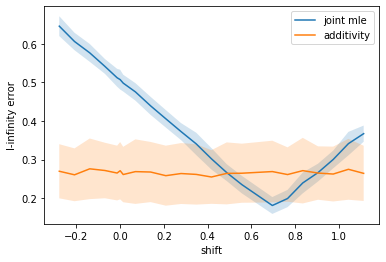

In [368]:
diff_list = (beta[1] - beta[0]) * overlap_list

# plt.figure(figsize = (9, 6))
plt.plot(diff_list, l_infty_beta_list)
plt.plot(diff_list, l_infty_beta_add_list)
plt.legend(['joint mle', 'additivity'])

# plt.fill_between(diff_list, bar_l_infty_beta_list[:,0], bar_l_infty_beta_list[:,1], color = 'red', alpha = 0.2)
# plt.fill_between(diff_list, bar_l_infty_beta_add_list[:,0], bar_l_infty_beta_add_list[:,1], color = 'blue', alpha = 0.2)
plt.fill_between(diff_list, l_infty_beta_list - std_l_infty_beta_list, 
                 l_infty_beta_list + std_l_infty_beta_list, alpha = 0.2)
plt.fill_between(diff_list, l_infty_beta_add_list - std_l_infty_beta_add_list, 
                 l_infty_beta_add_list + std_l_infty_beta_add_list, alpha = 0.2)
plt.xlabel('shift')
plt.ylabel('l-infinity error')

# plt.savefig('additivity_n' + str(n1) + 'n_bridge' + str(n_bridge) + '_average' + '.pdf',bbox_inches='tight')

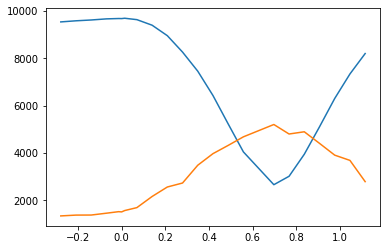

In [369]:
plt.plot(diff_list, rank_beta_list)
plt.plot(diff_list, rank_beta_add_list)

In [370]:
n_bridge = 20

In [371]:
import pickle
with open('additivity_n' + str(n1) + '_n_bridge' + str(n_bridge) + '_bridge_L' + str(bridge_L) + '_L' + str(L) + '_average' + '.pickle', 'wb') as f:
    pickle.dump([n1, n2, n_bridge, bridge_L, L, beta, overlap_list, l_infty_beta_list,
    std_l_infty_beta_list, bar_l_infty_beta_list, rank_beta_list, topk_beta_list, l_infty_beta_add_list, 
    std_l_infty_beta_add_list, bar_l_infty_beta_add_list, rank_beta_add_list, topk_beta_add_list], f)